# Model Preparation and XGBoost

The main purpose of this notebook is to prepare the dataset for modeling (train-test splitting, undersampling, and oversampling) and to create an XGBoost model.

# Imports

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression

from google.colab import drive
drive.mount('/content/drive')
drive_dir = '/content/drive/My Drive/Project_3/'

Mounted at /content/drive


# Loading the Data

In [2]:
df = pd.read_csv(drive_dir + 'data/promotion_train_data.csv')

In [1]:
df.head()

NameError: ignored

In [ ]:
df.shape

#Cleaning Data

In [5]:
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [6]:
df[['department', 'education', 'gender', 'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'KPIs_met >80%', 
    'awards_won?', 'avg_training_score', 'is_promoted']].sample(n=5)

,department,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
9505,Sales & Marketing,Bachelor's,f,other,1,31,3.0,6,0,0,64,1
35422,Operations,Master's & above,m,other,1,30,4.0,13,1,0,63,0
1571,R&D,Master's & above,m,other,2,31,4.0,3,0,0,85,0
26233,Finance,Bachelor's,f,other,1,30,3.0,5,0,0,60,0
39053,Operations,Bachelor's,m,other,1,30,2.0,3,1,0,57,0


In [7]:
df = df.drop('employee_id',axis = 1)

In [8]:
for col in df.columns:
  percent = 100 * df[col].isna().sum() / df.shape[0]
  percent = round(percent,2)
  print(f'{col}: {df[col].isna().sum()} ({percent}%) missing values')

department: 0 (0.0%) missing values
region: 0 (0.0%) missing values
education: 2409 (4.4%) missing values
gender: 0 (0.0%) missing values
recruitment_channel: 0 (0.0%) missing values
no_of_trainings: 0 (0.0%) missing values
age: 0 (0.0%) missing values
previous_year_rating: 4124 (7.52%) missing values
length_of_service: 0 (0.0%) missing values
KPIs_met >80%: 0 (0.0%) missing values
awards_won?: 0 (0.0%) missing values
avg_training_score: 0 (0.0%) missing values
is_promoted: 0 (0.0%) missing values


In [9]:
df['education'].unique()

array(["Master's & above", "Bachelor's", nan, 'Below Secondary'],
      dtype=object)

In [10]:
#Replacing NaN instead of dropping b/c I want to keep those rows
df['education'] = df.education.fillna('Unknown')

In [11]:
df['previous_year_rating'].unique()

array([ 5.,  3.,  1.,  4., nan,  2.])

In [12]:
#Ratings are 1-5, so 0 will mean employee was not here last year
df['previous_year_rating'] = df.previous_year_rating.fillna(0)

In [13]:
df.shape

(54808, 13)

In [14]:
df.dtypes

department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
KPIs_met >80%             int64
awards_won?               int64
avg_training_score        int64
is_promoted               int64
dtype: object

In [15]:
df.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [16]:
df['starting_age'] = df['age']-df['length_of_service']
df.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,starting_age
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,27
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,26
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,27
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,29
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,43


In [17]:
df['total_training_score'] = df['no_of_trainings']*df['avg_training_score']
df.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,starting_age,total_training_score
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,27,49
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,26,60
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,27,50
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,29,100
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,43,73


In [18]:
df = df.rename(columns={'KPIs_met >80%': 'KPIs_met>80%'})

In [19]:
df.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met>80%,awards_won?,avg_training_score,is_promoted,starting_age,total_training_score
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,27,49
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,26,60
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,27,50
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,29,100
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,43,73


In [20]:
df['previous_year_rating_norm'] = (df['previous_year_rating']-df['previous_year_rating'].min())/(df['previous_year_rating'].max()-df['previous_year_rating'].min())
df.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met>80%,awards_won?,avg_training_score,is_promoted,starting_age,total_training_score,previous_year_rating_norm
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,27,49,1.0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,26,60,1.0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,27,50,0.6
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,29,100,0.2
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,43,73,0.6


In [21]:
#based off of percentages of promotion. Lowered older than 40 with 0 rating bc only 11 people
def age_rating(row):
  if row['age'] <= 40 and row['previous_year_rating'] == 0:
    return 10
  elif row['age'] <= 40 and row['previous_year_rating'] == 1:
    return 2
  elif row['age'] <= 40 and row['previous_year_rating'] == 2:
    return 4
  elif row['age'] <= 40 and row['previous_year_rating'] == 3:
    return 7
  elif row['age'] <= 40 and row['previous_year_rating'] == 4:
    return 9
  elif row['age'] <= 40 and row['previous_year_rating'] == 5:
    return 12
  elif row['age'] > 40 and row['previous_year_rating'] == 0:
    return 6
  elif row['age'] > 40 and row['previous_year_rating'] == 1:
    return 1
  elif row['age'] > 40 and row['previous_year_rating'] == 2:
    return 3
  elif row['age'] > 40 and row['previous_year_rating'] == 3:
    return 5
  elif row['age'] > 40 and row['previous_year_rating'] == 4:
    return 8
  else:
    return 11


In [22]:
def age_KPI(row):
  if row['age'] <= 45 and row['KPIs_met>80%'] == 0:
    return 2
  elif row['age'] <= 45 and row['KPIs_met>80%'] == 1:
    return 4
  elif row['age'] > 45 and row['KPIs_met>80%'] == 0:
    return 3
  else:
    return 1

In [23]:
df['age_rating'] = df.apply(age_rating, axis=1)

In [24]:
df['age_KPI'] = df.apply(age_KPI, axis=1)

In [ ]:
df_hm = df[['KPIs_met>80%', 'is_promoted']]

In [ ]:
df_hm.head()

,KPIs_met>80%,is_promoted
0,1,0
1,0,0
2,0,0
3,0,0
4,0,0


In [ ]:
import seaborn as sns

In [ ]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(df_hm, annot=True, fmt="d", linewidths=.5, ax=ax)

Error in callback <function flush_figures at 0x7f4ea1265048> (for post_execute):


KeyboardInterrupt: ignored

#Looking for general facts

In [ ]:
#Rating 0 means they were not there last year
#What do these 8% of people do to get promoted?
for i in df['previous_year_rating'].unique():
  rating_df = df[df['previous_year_rating'] == i]
  total = rating_df.shape[0]
  promoted = rating_df[rating_df['is_promoted'] == 1].shape[0]
  percent = 100*promoted/total
  print(f"Employee's with previous year rating {i} were promoted {percent: .2f}% of the time. ({promoted} out of {total})")

Employee's with previous year rating 5.0 were promoted  16.36% of the time. (1921 out of 11741)
Employee's with previous year rating 3.0 were promoted  7.28% of the time. (1355 out of 18618)
Employee's with previous year rating 1.0 were promoted  1.41% of the time. (88 out of 6223)
Employee's with previous year rating 4.0 were promoted  7.94% of the time. (784 out of 9877)
Employee's with previous year rating 0.0 were promoted  8.22% of the time. (339 out of 4124)
Employee's with previous year rating 2.0 were promoted  4.28% of the time. (181 out of 4225)


In [ ]:
zero_df = df[df['previous_year_rating'] == 0]

In [ ]:
#Looks like average training score is an important factor for promotions
#0 is not promoted
#1 is promoted
for i, group in zero_df.groupby('is_promoted'):
  training_score_mean = group['avg_training_score'].mean()
  print(f"The average training score for {i} with a 0 previous year rating was {training_score_mean}")

for i, group in df.groupby('is_promoted'):
  training_score_mean = group['avg_training_score'].mean()
  print(f"The average training score for all people for {i} rating was {training_score_mean}")


The average training score for 0 with a 0 previous year rating was 62.589696169088505
The average training score for 1 with a 0 previous year rating was 71.929203539823
The average training score for all people for 0 rating was 62.64768647786199
The average training score for all people for 1 rating was 71.32519280205655


In [ ]:
#This seems hand picked
for department,group in df.groupby('department'):
  total = group.shape[0]
  promoted = group[group['is_promoted'] == 1].shape[0]
  perecnt = 100*promoted/total
  print(f"Employees in the {department} department were promoted {percent:.2f}% of the time. ({promoted} out of {total})")

Employees in the Analytics department were promoted 4.28% of the time. (512 out of 5352)
Employees in the Finance department were promoted 4.28% of the time. (206 out of 2536)
Employees in the HR department were promoted 4.28% of the time. (136 out of 2418)
Employees in the Legal department were promoted 4.28% of the time. (53 out of 1039)
Employees in the Operations department were promoted 4.28% of the time. (1023 out of 11348)
Employees in the Procurement department were promoted 4.28% of the time. (688 out of 7138)
Employees in the R&D department were promoted 4.28% of the time. (69 out of 999)
Employees in the Sales & Marketing department were promoted 4.28% of the time. (1213 out of 16840)
Employees in the Technology department were promoted 4.28% of the time. (768 out of 7138)


In [ ]:
#These are not as similar which is good
#Seems like females are being promoted more than males
for department,group in df.groupby('department'):
  male_df = group[group['gender'] == 'm']
  female_df = group[group['gender'] == 'f']
  total_male = male_df.shape[0]
  total_female = female_df.shape[0]
  promoted_male = male_df[male_df['is_promoted'] == 1].shape[0]
  promoted_female = female_df[female_df['is_promoted'] == 1].shape[0]
  percent_male = 100*promoted_male/total_male
  percent_female = 100*promoted_female/total_female
  print(f"Males in the {department} department were promoted {percent_male:.2f}% of the time. ({promoted_male} out of {total_male})")
  print(f"Females in the {department} department were promoted {percent_female:.2f}% of the time. ({promoted_female} out of {total_female})")
  print('='*100)

Males in the Analytics department were promoted 9.30% of the time. (450 out of 4839)
Females in the Analytics department were promoted 12.09% of the time. (62 out of 513)
Males in the Finance department were promoted 8.14% of the time. (151 out of 1855)
Females in the Finance department were promoted 8.08% of the time. (55 out of 681)
Males in the HR department were promoted 5.52% of the time. (78 out of 1412)
Females in the HR department were promoted 5.77% of the time. (58 out of 1006)
Males in the Legal department were promoted 5.28% of the time. (47 out of 890)
Females in the Legal department were promoted 4.03% of the time. (6 out of 149)
Males in the Operations department were promoted 8.71% of the time. (581 out of 6671)
Females in the Operations department were promoted 9.45% of the time. (442 out of 4677)
Males in the Procurement department were promoted 7.87% of the time. (303 out of 3851)
Females in the Procurement department were promoted 11.71% of the time. (385 out of 328

# Model Building Preparation

In [25]:
df_encoded = df.copy()

In [26]:
from sklearn.preprocessing import LabelEncoder

In [27]:
for c in df_encoded.columns:
  if c != 'default':  
    if df_encoded[c].dtype == object:  #If it is a string, then encode it. 
        try:  
            le = LabelEncoder()           
            le.fit(df_encoded[c].unique())    
            df_encoded[c] = le.transform(df_encoded[c])  
        except Exception as e:         
            print(c)         
            print(e)

In [28]:
df_encoded.dtypes

department                     int64
region                         int64
education                      int64
gender                         int64
recruitment_channel            int64
no_of_trainings                int64
age                            int64
previous_year_rating         float64
length_of_service              int64
KPIs_met>80%                   int64
awards_won?                    int64
avg_training_score             int64
is_promoted                    int64
starting_age                   int64
total_training_score           int64
previous_year_rating_norm    float64
age_rating                     int64
age_KPI                        int64
dtype: object

In [29]:
df_encoded['gender'].value_counts()

1    38496
0    16312
Name: gender, dtype: int64

In [30]:
df['gender'].value_counts()

m    38496
f    16312
Name: gender, dtype: int64

In [31]:
df.columns

Index(['department', 'region', 'education', 'gender', 'recruitment_channel',
       'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service',
       'KPIs_met>80%', 'awards_won?', 'avg_training_score', 'is_promoted',
       'starting_age', 'total_training_score', 'previous_year_rating_norm',
       'age_rating', 'age_KPI'],
      dtype='object')

In [32]:
df_encoded[['department', 'education', 'gender', 'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'KPIs_met>80%', 
    'awards_won?', 'avg_training_score', 'is_promoted']].sample(n=5)

,department,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met>80%,awards_won?,avg_training_score,is_promoted
38069,4,0,1,0,1,27,3.0,3,0,0,56,0
23112,7,2,1,2,1,38,3.0,7,0,0,44,0
16851,8,2,1,0,1,31,3.0,3,0,0,79,0
6544,8,0,0,0,1,29,0.0,1,0,0,77,0
14104,7,0,0,0,1,30,3.0,6,1,0,47,0


In [33]:
from sklearn.model_selection import train_test_split

In [34]:
female_df = df_encoded[df_encoded['gender']==0]
male_df = df_encoded[df_encoded['gender']==1]

female_train_df, female_test_df = train_test_split(female_df, test_size=0.3, random_state=0, stratify=female_df['is_promoted'])
male_train_df, male_test_df = train_test_split(male_df, test_size=0.3, random_state=0, stratify=male_df['is_promoted'])

In [35]:
feat_cols = ['department', 'region', 'education', 'gender', 'recruitment_channel', 'no_of_trainings', 'age', 
             'previous_year_rating', 'length_of_service', 'KPIs_met>80%', 'awards_won?', 'avg_training_score', 
             'starting_age', 'total_training_score', 'previous_year_rating_norm', 'age_rating', 'age_KPI']
target_col = 'is_promoted'

female_X_train = female_train_df[feat_cols]
female_y_train = female_train_df[target_col]

male_X_train = male_train_df[feat_cols]
male_y_train = male_train_df[target_col]

female_X_test = female_test_df[feat_cols]
female_y_test = female_test_df[target_col]

male_X_test = male_test_df[feat_cols]
male_y_test = male_test_df[target_col]

In [36]:
female_X_train.to_csv(drive_dir + 'data/female_X_train.csv')

In [37]:
female_y_train.to_csv(drive_dir + 'data/female_y_train.csv')

In [38]:
male_X_train.to_csv(drive_dir + 'data/male_X_train.csv')

In [39]:
male_y_train.to_csv(drive_dir + 'data/male_y_train.csv')

In [40]:
female_X_test.to_csv(drive_dir + 'data/female_X_test.csv')

In [41]:
female_y_test.to_csv(drive_dir + 'data/female_y_test.csv')

In [42]:
male_X_test.to_csv(drive_dir + 'data/male_X_test.csv')

In [ ]:
male_y_test.to_csv(drive_dir + 'data/male_y_test.csv')

In [ ]:
female_train_df.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met>80%,awards_won?,avg_training_score,is_promoted,starting_age,total_training_score,previous_year_rating_norm,age_rating,age_KPI
5937,7,29,0,0,0,1,32,2.0,3,0,0,51,0,29,51,0.4,4,2
24479,5,11,2,0,0,3,49,3.0,6,1,0,70,0,43,210,0.6,5,1
49931,5,2,0,0,0,1,32,2.0,5,0,0,71,0,27,71,0.4,4,2
20282,8,11,0,0,2,1,37,5.0,10,0,0,79,0,27,79,1.0,12,2
14658,5,11,2,0,0,1,51,3.0,6,0,0,68,0,45,68,0.6,5,3


## Undersampling

In [ ]:
female_train_df['is_promoted'].value_counts()

0    10391
1     1027
Name: is_promoted, dtype: int64

In [ ]:
male_train_df['is_promoted'].value_counts()

0    24706
1     2241
Name: is_promoted, dtype: int64

In [ ]:
# Get only the customers who did not get promoted
female_train_no_df = female_train_df[female_train_df['is_promoted'] == 0]
# Then select of them to match the "1" is_promoted employees
female_train_no_df = female_train_no_df.sample(1027)

# Also grab the promoted employees
female_train_yes_df = female_train_df[female_train_df['is_promoted'] == 1]

# And now stick both DataFrames together to make a new undersampled training set
female_train_under_df = pd.concat([female_train_no_df, female_train_yes_df])

In [ ]:
# Get only the customers who did not get promoted
male_train_no_df = male_train_df[male_train_df['is_promoted'] == 0]
# Then select of them to match the "1" is_promoted employees
male_train_no_df = male_train_no_df.sample(2241)

# Also grab the promoted employees
male_train_yes_df = male_train_df[male_train_df['is_promoted'] == 1]

# And now stick both DataFrames together to make a new undersampled training set
male_train_under_df = pd.concat([male_train_no_df, male_train_yes_df])

In [ ]:
female_train_under_df['is_promoted'].value_counts()

1    1027
0    1027
Name: is_promoted, dtype: int64

In [ ]:
male_train_under_df['is_promoted'].value_counts()

1    2241
0    2241
Name: is_promoted, dtype: int64

In [ ]:
feat_cols = ['department', 'region', 'education', 'gender', 'recruitment_channel', 'no_of_trainings', 'age', 
             'previous_year_rating', 'length_of_service', 'KPIs_met>80%', 'awards_won?', 'avg_training_score', 
             'starting_age', 'total_training_score', 'previous_year_rating_norm', 'age_rating', 'age_KPI']
target_col = 'is_promoted'

female_X_train_under = female_train_under_df[feat_cols]
female_y_train_under = female_train_under_df[target_col]

In [ ]:
male_X_train_under = male_train_under_df[feat_cols]
male_y_train_under = male_train_under_df[target_col]

In [ ]:
female_X_train_under.to_csv(drive_dir + 'data/female_X_train_under.csv')

In [ ]:
female_y_train_under.to_csv(drive_dir + 'data/female_y_train_under.csv')

In [ ]:
male_X_train_under.to_csv(drive_dir + 'data/male_X_train_under.csv')

In [ ]:
male_y_train_under.to_csv(drive_dir + 'data/male_y_train_under.csv')

## Oversampling

In [43]:
female_train_df['is_promoted'].value_counts()

0    10391
1     1027
Name: is_promoted, dtype: int64

In [44]:
male_train_df['is_promoted'].value_counts()

0    24706
1     2241
Name: is_promoted, dtype: int64

In [45]:
female_train_yes_df = female_train_df[female_train_df['is_promoted'] == 1]
female_train_yes_df = female_train_yes_df.sample(10391, replace=True)

female_train_no_df = female_train_df[female_train_df['is_promoted'] == 0]

# And now stick both DataFrames together to make a new oversampled training set
female_train_over_df = pd.concat([female_train_no_df, female_train_yes_df])

In [46]:
male_train_yes_df = male_train_df[male_train_df['is_promoted'] == 1]
male_train_yes_df = male_train_yes_df.sample(24706, replace=True)

male_train_no_df = male_train_df[male_train_df['is_promoted'] == 0]

# And now stick both DataFrames together to make a new oversampled training set
male_train_over_df = pd.concat([male_train_no_df, male_train_yes_df])

In [47]:
male_train_over_df.shape

(49412, 18)

In [48]:
male_test_df.shape

(11549, 18)

In [ ]:
female_train_over_df['is_promoted'].value_counts()

1    10391
0    10391
Name: is_promoted, dtype: int64

In [ ]:
male_train_over_df['is_promoted'].value_counts()

1    24706
0    24706
Name: is_promoted, dtype: int64

In [ ]:
feat_cols = ['department', 'region', 'education', 'gender', 'recruitment_channel', 'no_of_trainings', 'age', 
             'previous_year_rating', 'length_of_service', 'KPIs_met>80%', 'awards_won?', 'avg_training_score', 
             'starting_age', 'total_training_score', 'previous_year_rating_norm', 'age_rating', 'age_KPI']
target_col = 'is_promoted'

female_X_train_over = female_train_over_df[feat_cols]
female_y_train_over = female_train_over_df[target_col]

In [ ]:
male_X_train_over = male_train_over_df[feat_cols]
male_y_train_over = male_train_over_df[target_col]

In [ ]:
female_X_train_over.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met>80%,awards_won?,avg_training_score,starting_age,total_training_score,previous_year_rating_norm,age_rating,age_KPI
5937,7,29,0,0,0,1,32,2.0,3,0,0,51,29,51,0.4,4,2
24479,5,11,2,0,0,3,49,3.0,6,1,0,70,43,210,0.6,5,1
49931,5,2,0,0,0,1,32,2.0,5,0,0,71,27,71,0.4,4,2
20282,8,11,0,0,2,1,37,5.0,10,0,0,79,27,79,1.0,12,2
14658,5,11,2,0,0,1,51,3.0,6,0,0,68,45,68,0.6,5,3


In [ ]:
female_X_train_over.to_csv(drive_dir + 'data/female_X_train_over.csv')

In [ ]:
female_y_train_over.to_csv(drive_dir + 'data/female_y_train_over.csv')

In [ ]:
male_X_train_over.to_csv(drive_dir + 'data/male_X_train_over.csv')

In [ ]:
male_y_train_over.to_csv(drive_dir + 'data/male_y_train_over.csv')

# XGBoost

## GridsearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier

In [ ]:
xgb_clf = XGBClassifier(tree_method='gpu_hist')
hyperparams = {'n_estimators': [100, 150, 200],
               'max_depth': [50, 100, 150, 200, 250],
               'learning_rate': [1e-4, 1e-3, 1e-2, 0.1, 1]}

grid_search = GridSearchCV(estimator=xgb_clf,
                           param_grid=hyperparams)

grid_search.fit(male_X_train_over, male_y_train_over)

KeyboardInterrupt: ignored

In [ ]:
grid_search.best_params_

NameError: ignored

In [ ]:
best_model = grid_search.best_estimator_

In [ ]:
best_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
xgb_clf = XGBClassifier()
hyperparams = {'n_estimators': [5, 10, 25, 50, 100],
               'max_depth': [5, 10, 25, 50, 100, 150],
               'learning_rate': [1e-4, 1e-3, 1e-2, 0.1, 1]}

grid_search = GridSearchCV(estimator=xgb_clf,
                           param_grid=hyperparams)

grid_search.fit(female_X_train_over, female_y_train_over)

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1],
                         'max_depth': [5, 10, 25, 50, 100, 150],
                         'n_estimato

In [ ]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 100}

## Male Under

In [ ]:
from xgboost.sklearn import XGBClassifier
xgb_clf_male_under = XGBClassifier(learning_rate=0.1, max_depth=50, n_estimators=100)
xgb_clf_male_under.fit(male_X_train_under, male_y_train_under)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

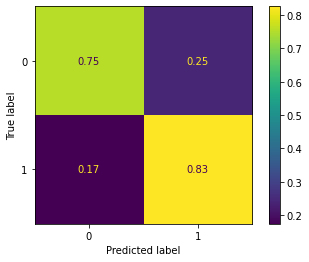

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(xgb_clf_male_under, male_X_test, male_y_test, normalize='true')

In [ ]:
from sklearn.metrics import accuracy_score
male_under_pred = xgb_clf_male_under.predict(male_X_test)
print("Accuracy for male undersampled model: %.2f" % (accuracy_score(male_y_test, pred) * 100))

Accuracy for male undersampled model: 76.08


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(male_y_test, male_under_pred))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85     10589
           1       0.23      0.83      0.36       960

    accuracy                           0.76     11549
   macro avg       0.61      0.79      0.61     11549
weighted avg       0.92      0.76      0.81     11549



In [ ]:
featuredf = pd.DataFrame(xgb_clf_male_under.feature_importances_, male_X_train_under.columns)

In [ ]:
featuredf = featuredf.sort_values(by=0, ascending=False)
featuredf[0] = featuredf[0]*100
featuredf = featuredf[:10]

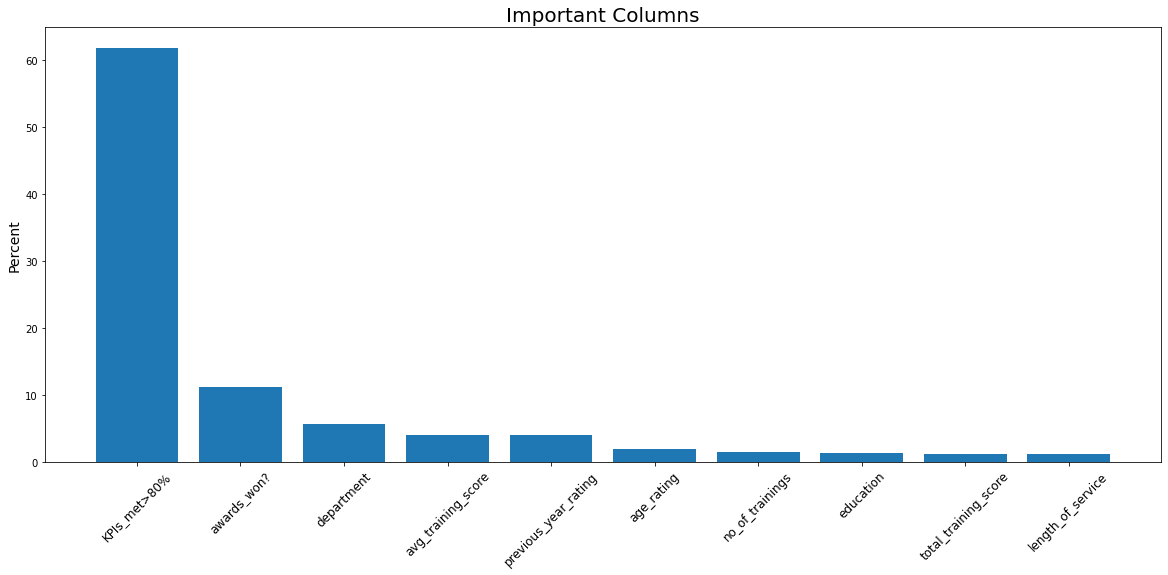

In [ ]:
plt.figure(figsize=(20, 8))

x = featuredf.index
y = featuredf[0]

plt.title('Important Columns', fontsize =20)
plt.bar(x, y)
plt.xticks(rotation=45, fontsize = 12)
plt.ylabel('Percent', fontsize=14);

## Male Over

In [ ]:
xgb_clf_male_over = XGBClassifier(learning_rate=0.1, max_depth=50, n_estimators=100)

In [ ]:
xgb_clf_male_over.fit(male_X_train_over, male_y_train_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

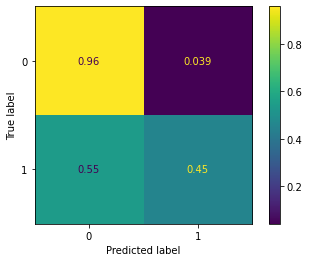

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(xgb_clf_male_over, male_X_test, male_y_test, normalize='true')

In [ ]:
from sklearn.metrics import accuracy_score
male_over_pred = xgb_clf_male_over.predict(male_X_test)
print("Accuracy for male oversampled model: %.2f" % (accuracy_score(male_y_test, male_over_pred) * 100))

Accuracy for male oversampled model: 91.86


In [ ]:
male_pred_df = pd.DataFrame(male_over_pred, columns=['predictions'])

In [ ]:
male_pred_df.head()

,predictions
0,0
1,0
2,0
3,0
4,0


In [ ]:
male_pred_df.to_csv(drive_dir + 'data/male_pred_xgb.csv')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(male_y_test, male_over_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     10589
           1       0.51      0.45      0.48       960

    accuracy                           0.92     11549
   macro avg       0.73      0.71      0.72     11549
weighted avg       0.91      0.92      0.92     11549



In [ ]:
featuredf = pd.DataFrame(xgb_clf_male_over.feature_importances_, male_X_train_over.columns)

In [ ]:
featuredf = featuredf.sort_values(by=0, ascending=False)
featuredf[0] = featuredf[0]*100
featuredf = featuredf[:10]

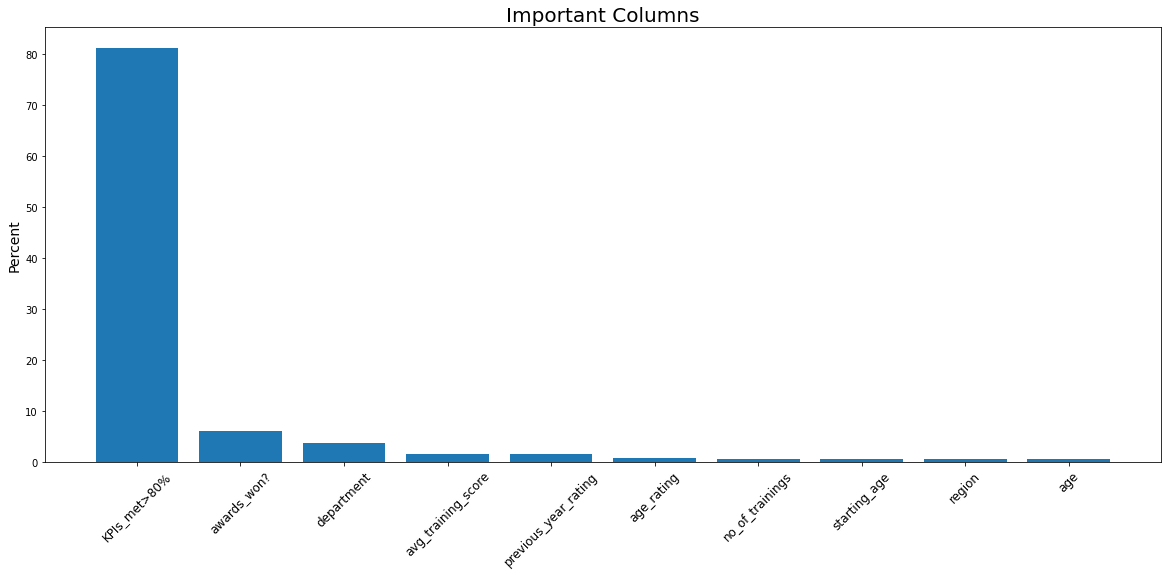

In [ ]:
plt.figure(figsize=(20, 8))

x = featuredf.index
y = featuredf[0]

plt.title('Important Columns', fontsize =20)
plt.bar(x, y)
plt.xticks(rotation=45, fontsize = 12)
plt.ylabel('Percent', fontsize=14);

In [ ]:
import joblib

In [ ]:
joblib.dump(xgb_clf_male_over, drive_dir + 'models/male_over_xgb.joblib')

['/content/drive/My Drive/Project_3/models/male_over_xgb.joblib']

In [ ]:
male_X_train_over.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met>80%,awards_won?,avg_training_score,starting_age,total_training_score,previous_year_rating_norm,age_rating,age_KPI
11574,2,28,0,1,0,1,29,5.0,2,1,0,50,27,50,1.0,12,4
9454,7,22,0,1,0,1,35,1.0,5,0,0,49,30,49,0.2,2,2
34528,4,10,0,1,0,1,42,3.0,6,0,0,61,36,61,0.6,5,2
1350,4,19,2,1,0,1,46,5.0,14,0,0,58,32,58,1.0,11,3
14455,0,2,0,1,0,2,40,3.0,4,0,0,83,36,166,0.6,7,2


In [ ]:
male_KPI_df = male_df[male_df['KPIs_met>80%']==1]

In [ ]:
male_noKPI_df = male_df[male_df['KPIs_met>80%']==0]

In [ ]:
male_KPI_train_df, male_KPI_test_df = train_test_split(male_KPI_df, test_size=0.3, random_state=0, stratify=male_KPI_df['is_promoted'])
male_noKPI_train_df, male_noKPI_test_df = train_test_split(male_noKPI_df, test_size=0.3, random_state=0, stratify=male_noKPI_df['is_promoted'])

In [ ]:
feat_cols = ['department', 'region', 'education', 'gender', 'recruitment_channel', 'no_of_trainings', 'age', 
             'previous_year_rating', 'length_of_service', 'awards_won?', 'avg_training_score', 
             'starting_age', 'total_training_score', 'previous_year_rating_norm', 'age_rating']
target_col = 'is_promoted'

male_KPI_X_train = male_KPI_train_df[feat_cols]
male_KPI_y_train = male_KPI_train_df[target_col]

male_noKPI_X_train = male_noKPI_train_df[feat_cols]
male_noKPI_y_train = male_noKPI_train_df[target_col]

male_KPI_X_test = male_KPI_test_df[feat_cols]
male_KPI_y_test = male_KPI_test_df[target_col]

male_noKPI_X_test = male_noKPI_test_df[feat_cols]
male_noKPI_y_test = male_noKPI_test_df[target_col]

In [ ]:
male_KPI_X_train.columns

Index(['department', 'region', 'education', 'gender', 'recruitment_channel',
       'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service',
       'awards_won?', 'avg_training_score', 'starting_age',
       'total_training_score', 'previous_year_rating_norm', 'age_rating'],
      dtype='object')

In [ ]:
male_KPI_train_df['is_promoted'].value_counts()

0    7613
1    1558
Name: is_promoted, dtype: int64

In [ ]:
male_noKPI_train_df['is_promoted'].value_counts()

0    17093
1      682
Name: is_promoted, dtype: int64

In [ ]:
male_KPI_train_yes_df = male_KPI_train_df[male_KPI_train_df['is_promoted'] == 1]
male_KPI_train_yes_df = male_KPI_train_yes_df.sample(7613, replace=True)

male_KPI_train_no_df = male_KPI_train_df[male_KPI_train_df['is_promoted'] == 0]

# And now stick both DataFrames together to make a new oversampled training set
male_KPI_train_over_df = pd.concat([male_KPI_train_no_df, male_KPI_train_yes_df])

In [ ]:
male_noKPI_train_yes_df = male_noKPI_train_df[male_noKPI_train_df['is_promoted'] == 1]
male_noKPI_train_yes_df = male_noKPI_train_yes_df.sample(17093, replace=True)

male_noKPI_train_no_df = male_noKPI_train_df[male_noKPI_train_df['is_promoted'] == 0]

# And now stick both DataFrames together to make a new oversampled training set
male_noKPI_train_over_df = pd.concat([male_noKPI_train_no_df, male_noKPI_train_yes_df])

In [ ]:
male_KPI_train_over_df['is_promoted'].value_counts()

1    7613
0    7613
Name: is_promoted, dtype: int64

In [ ]:
male_noKPI_train_over_df['is_promoted'].value_counts()

1    17093
0    17093
Name: is_promoted, dtype: int64

In [ ]:
feat_cols = ['department', 'region', 'education', 'gender', 'recruitment_channel', 'no_of_trainings', 'age', 
             'previous_year_rating', 'length_of_service', 'awards_won?', 'avg_training_score', 
             'starting_age', 'total_training_score', 'previous_year_rating_norm', 'age_rating']
target_col = 'is_promoted'

male_KPI_X_train_over = male_KPI_train_over_df[feat_cols]
male_KPI_y_train_over = male_KPI_train_over_df[target_col]

In [ ]:
male_noKPI_X_train_over = male_noKPI_train_over_df[feat_cols]
male_noKPI_y_train_over = male_noKPI_train_over_df[target_col]

In [ ]:
xgb_clf = XGBClassifier(tree_method='gpu_hist')
hyperparams = {'n_estimators': [100, 150, 200],
               'max_depth': [50, 100, 150, 200, 250],
               'learning_rate': [1e-4, 1e-3, 1e-2, 0.1, 1]}

grid_search = GridSearchCV(estimator=xgb_clf,
                           param_grid=hyperparams)

grid_search.fit(male_KPI_X_train_over, male_KPI_y_train_over)

In [ ]:
xgb_clf_male_KPI_over = XGBClassifier(learning_rate=0.1, max_depth=50, n_estimators=100)

In [ ]:
xgb_clf_male_KPI_over.fit(male_KPI_X_train_over, male_KPI_y_train_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

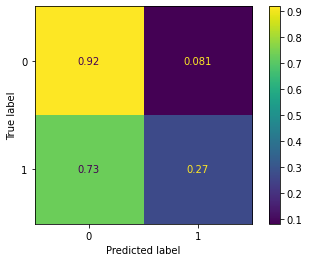

In [ ]:
plot_confusion_matrix(xgb_clf_male_KPI_over, male_KPI_X_test, male_KPI_y_test, normalize='true')

In [ ]:
male_KPI_over_pred = xgb_clf_male_KPI_over.predict(male_KPI_X_test)
print("Accuracy for male KPI oversampled model: %.2f" % (accuracy_score(male_KPI_y_test, male_KPI_over_pred) * 100))

Accuracy for male KPI oversampled model: 80.84


In [ ]:
print(classification_report(male_KPI_y_test, male_KPI_over_pred))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      3263
           1       0.40      0.27      0.32       668

    accuracy                           0.81      3931
   macro avg       0.63      0.59      0.61      3931
weighted avg       0.78      0.81      0.79      3931



In [ ]:
xgb_clf_male_noKPI_over = XGBClassifier(learning_rate=0.1, max_depth=50, n_estimators=100)

In [ ]:
xgb_clf_male_noKPI_over.fit(male_noKPI_X_train_over, male_noKPI_y_train_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

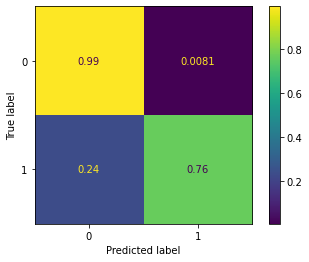

In [ ]:
plot_confusion_matrix(xgb_clf_male_noKPI_over, male_noKPI_X_test, male_noKPI_y_test, normalize='true')

In [ ]:
male_noKPI_over_pred = xgb_clf_male_noKPI_over.predict(male_noKPI_X_test)
print("Accuracy for male noKPI oversampled model: %.2f" % (accuracy_score(male_noKPI_y_test, male_noKPI_over_pred) * 100))

Accuracy for male noKPI oversampled model: 98.32


In [ ]:
print(classification_report(male_noKPI_y_test, male_noKPI_over_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7326
           1       0.79      0.76      0.78       293

    accuracy                           0.98      7619
   macro avg       0.89      0.88      0.88      7619
weighted avg       0.98      0.98      0.98      7619



## Female Under

In [ ]:
xgb_clf_female_under = XGBClassifier(learning_rate=0.1, max_depth=50, n_estimators=100)

In [ ]:
xgb_clf_female_under.fit(female_X_train_under, female_y_train_under)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

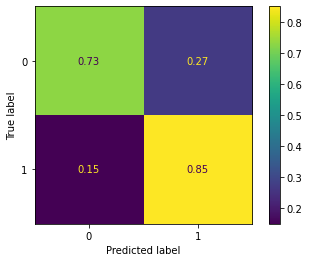

In [ ]:
plot_confusion_matrix(xgb_clf_female_under, female_X_test, female_y_test, normalize='true')

In [ ]:
female_under_pred = xgb_clf_female_under.predict(female_X_test)
print("Accuracy for female undersampled model: %.2f" % (accuracy_score(female_y_test, female_under_pred) * 100))

Accuracy for female undersampled model: 74.23


In [ ]:
print(classification_report(female_y_test, female_under_pred))

              precision    recall  f1-score   support

           0       0.98      0.73      0.84      4454
           1       0.24      0.85      0.37       440

    accuracy                           0.74      4894
   macro avg       0.61      0.79      0.61      4894
weighted avg       0.91      0.74      0.80      4894



In [ ]:
featuredf = pd.DataFrame(xgb_clf_female_under.feature_importances_, female_X_train_under.columns)

In [ ]:
featuredf = featuredf.sort_values(by=0, ascending=False)
featuredf[0] = featuredf[0]*100
featuredf = featuredf[:10]

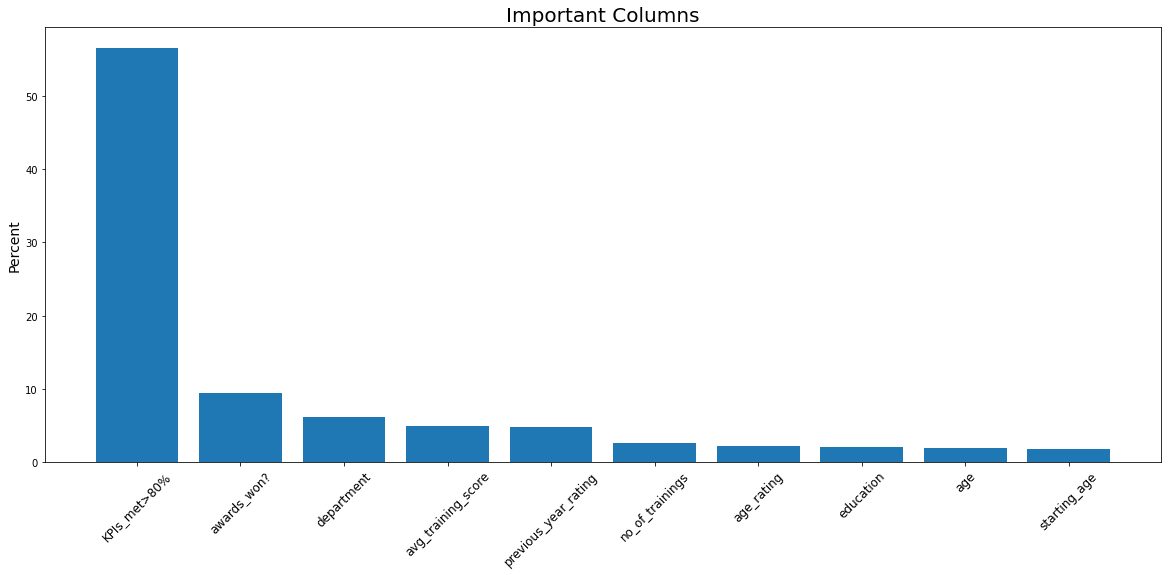

In [ ]:
plt.figure(figsize=(20, 8))

x = featuredf.index
y = featuredf[0]

plt.title('Important Columns', fontsize =20)
plt.bar(x, y)
plt.xticks(rotation=45, fontsize = 12)
plt.ylabel('Percent', fontsize=14);

## Female Over

In [ ]:
xgb_clf_female_over = XGBClassifier(learning_rate=0.1, max_depth=50, n_estimators=100)

In [ ]:
xgb_clf_female_over.fit(female_X_train_over, female_y_train_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

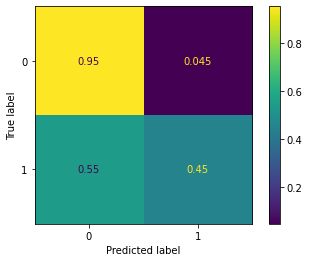

In [ ]:
plot_confusion_matrix(xgb_clf_female_over, female_X_test, female_y_test, normalize='true')

In [ ]:
female_over_pred = xgb_clf_female_over.predict(female_X_test)
print("Accuracy for female oversampled model: %.2f" % (accuracy_score(female_y_test, female_over_pred) * 100))

Accuracy for female oversampled model: 90.97


In [ ]:
female_pred_df = pd.DataFrame(female_over_pred, columns=['predictions'])

In [ ]:
female_pred_df.head()

,predictions
0,0
1,0
2,0
3,0
4,0


In [ ]:
female_pred_df.to_csv(drive_dir + 'data/female_pred_xgb.csv')

In [ ]:
print(classification_report(female_y_test, female_over_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4454
           1       0.50      0.45      0.47       440

    accuracy                           0.91      4894
   macro avg       0.72      0.70      0.71      4894
weighted avg       0.91      0.91      0.91      4894



In [ ]:
featuredf = pd.DataFrame(xgb_clf_female_over.feature_importances_, female_X_train_over.columns)

In [ ]:
featuredf = featuredf.sort_values(by=0, ascending=False)
featuredf[0] = featuredf[0]*100
featuredf = featuredf[:10]

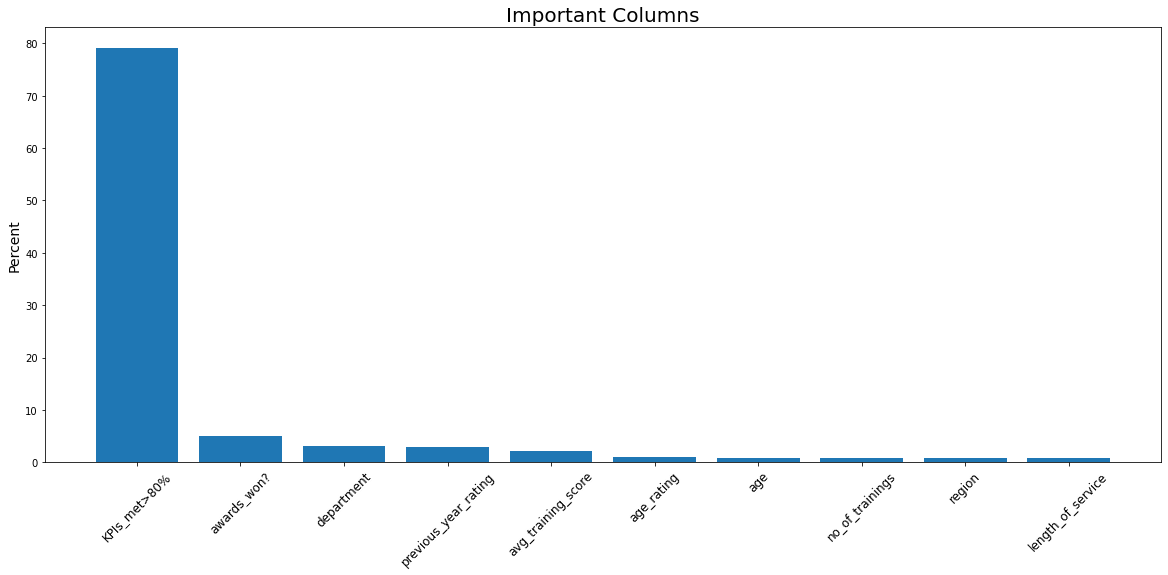

In [ ]:
plt.figure(figsize=(20, 8))

x = featuredf.index
y = featuredf[0]

plt.title('Important Columns', fontsize =20)
plt.bar(x, y)
plt.xticks(rotation=45, fontsize = 12)
plt.ylabel('Percent', fontsize=14);

# Investigating Predictions

In [ ]:
female_X_test['preds'] = female_pred

In [ ]:
female_X_test.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met>80%,awards_won?,avg_training_score,starting_age,total_training_score,previous_year_rating_norm,age_rating,age_KPI,preds
26777,4,11,2,0,0,2,37,4.0,2,1,0,59,35,118,0.8,9,4,0
15134,2,14,0,0,1,1,29,4.0,7,1,0,52,22,52,0.8,9,4,0
40991,8,16,2,0,0,1,30,0.0,1,0,0,78,29,78,0.0,10,2,0
44895,4,10,0,0,2,1,39,5.0,7,1,0,60,32,60,1.0,12,4,0
16968,5,18,0,0,0,1,35,5.0,2,1,0,68,33,68,1.0,12,4,0


In [ ]:
female_test = pd.merge(female_X_test, female_y_test, left_index=True, right_index=True)

In [ ]:
female_correct_test = female_test[female_test['is_promoted'] == female_test['preds']]

In [ ]:
female_incorrect_test = female_test[female_test['is_promoted'] != female_test['preds']]

In [ ]:
female_incorrect_test.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met>80%,awards_won?,avg_training_score,starting_age,total_training_score,previous_year_rating_norm,age_rating,age_KPI,preds,is_promoted
48577,8,31,0,0,0,1,34,3.0,5,1,0,79,29,79,0.6,7,4,1,0
39178,7,17,2,0,0,1,37,5.0,8,1,0,50,29,50,1.0,12,4,0,1
40970,5,11,2,0,2,1,39,5.0,7,1,0,74,32,74,1.0,12,4,0,1
15254,5,31,0,0,0,1,34,4.0,6,1,1,69,28,69,0.8,9,4,0,1
34919,5,2,2,0,0,1,31,5.0,7,1,0,68,24,68,1.0,12,4,1,0


In [ ]:
female_correct_test.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met>80%,awards_won?,avg_training_score,starting_age,total_training_score,previous_year_rating_norm,age_rating,age_KPI,preds,is_promoted
26777,4,11,2,0,0,2,37,4.0,2,1,0,59,35,118,0.8,9,4,0,0
15134,2,14,0,0,1,1,29,4.0,7,1,0,52,22,52,0.8,9,4,0,0
40991,8,16,2,0,0,1,30,0.0,1,0,0,78,29,78,0.0,10,2,0,0
44895,4,10,0,0,2,1,39,5.0,7,1,0,60,32,60,1.0,12,4,0,0
16968,5,18,0,0,0,1,35,5.0,2,1,0,68,33,68,1.0,12,4,0,0


In [ ]:
female_incorrect_test.shape

(436, 19)

In [ ]:
female_correct_test.shape

(4458, 19)

In [ ]:
def make_hist(column):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
  ax1 = female_incorrect_test[column].plot(kind='hist', ax=axes[0])
  ax2 = female_correct_test[column].plot(kind='hist', ax =axes[1])
  ax1.set_title('Incorrect Female')
  ax2.set_title('Correct Female')

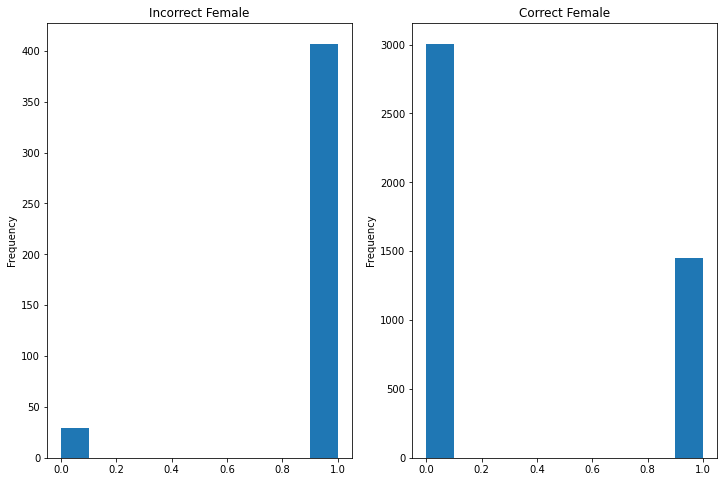

In [ ]:
make_hist(column='KPIs_met>80%')

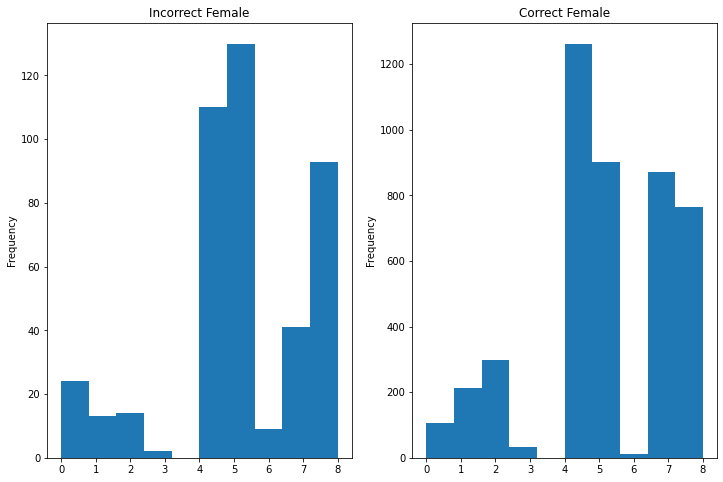

In [ ]:
make_hist(column='department')

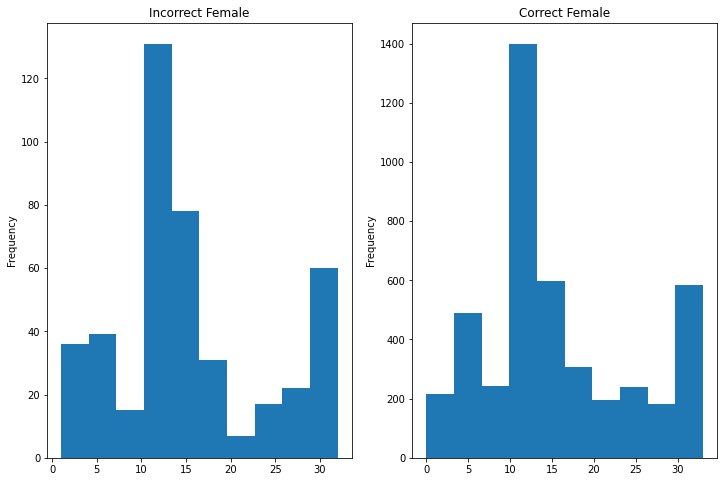

In [ ]:
make_hist(column='region')

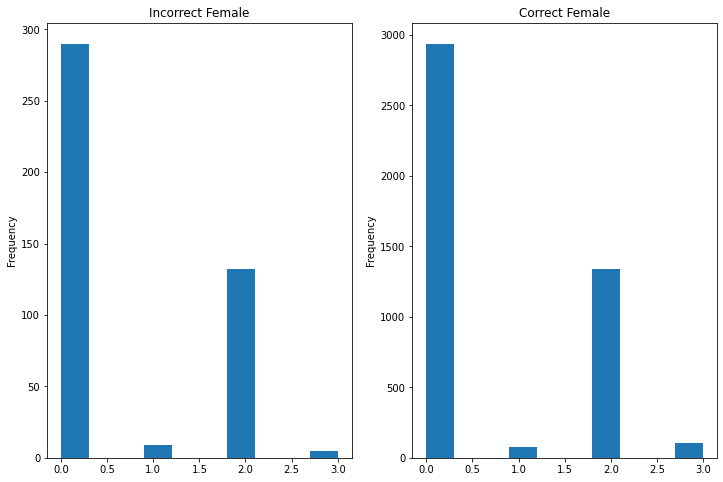

In [ ]:
make_hist(column='education')

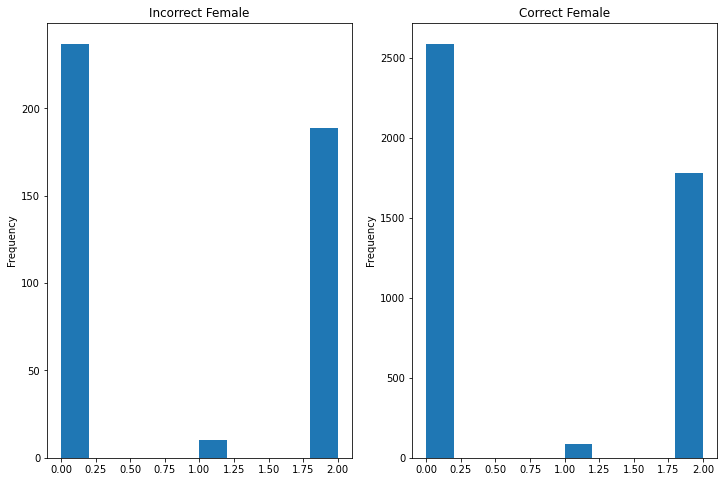

In [ ]:
make_hist(column='recruitment_channel')

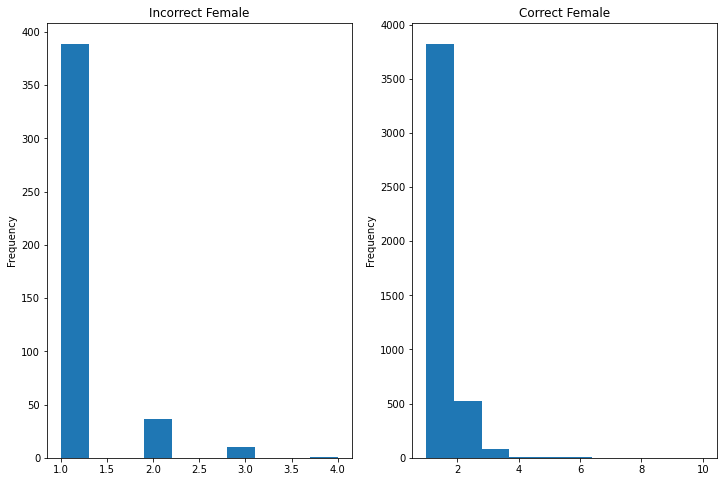

In [ ]:
make_hist(column='no_of_trainings')

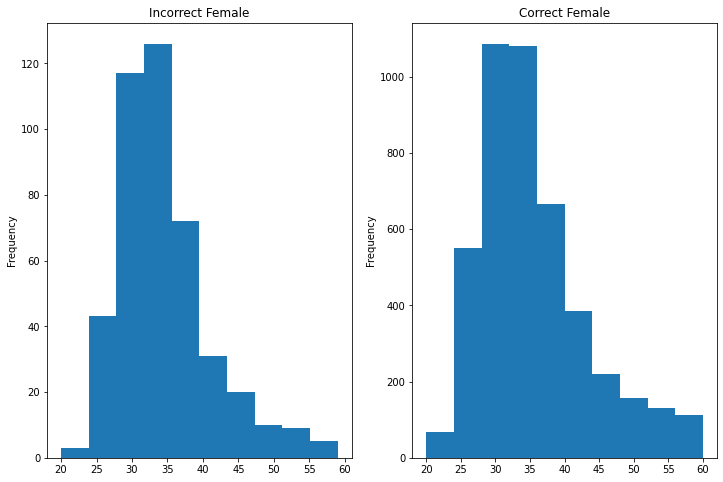

In [ ]:
make_hist(column='age')

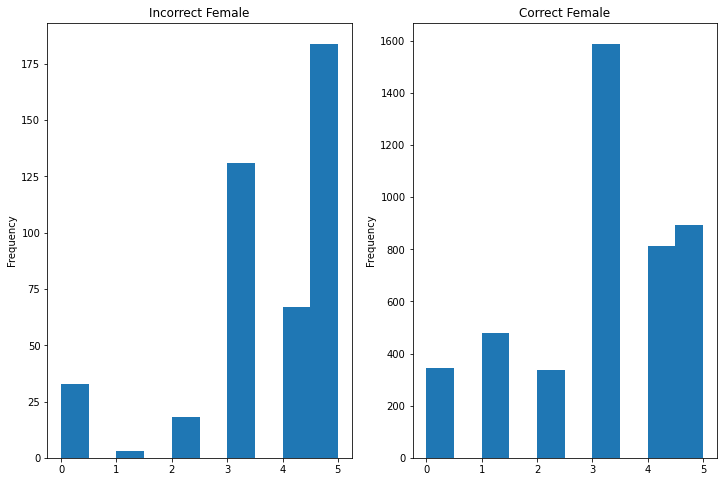

In [ ]:
make_hist(column='previous_year_rating')

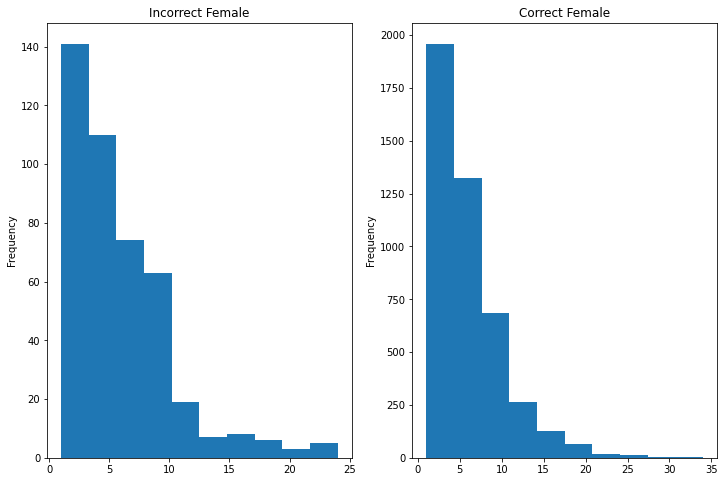

In [ ]:
make_hist(column='length_of_service')

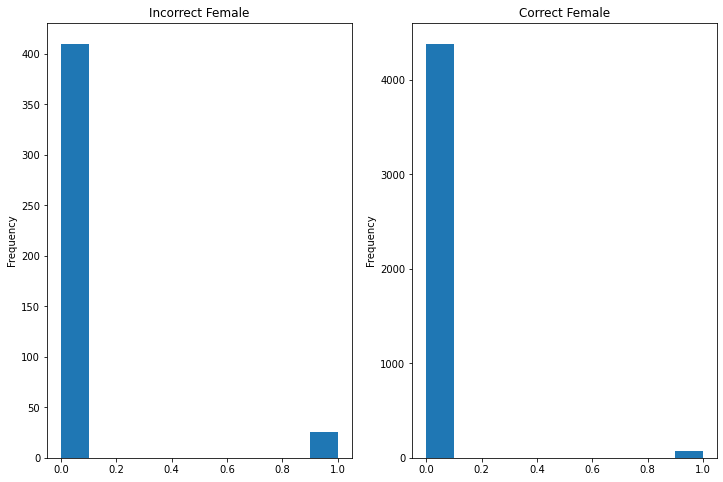

In [ ]:
make_hist(column='awards_won?')

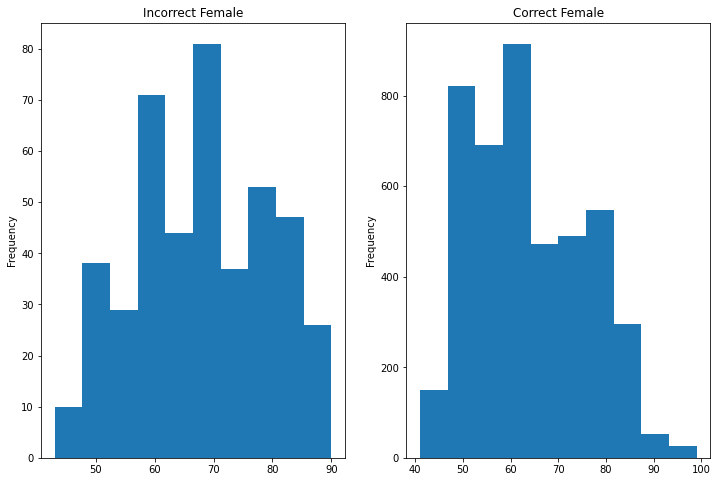

In [ ]:
make_hist(column='avg_training_score')

In [ ]:
incorrect_test.columns

Index(['department', 'region', 'education', 'gender', 'recruitment_channel',
       'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service',
       'KPIs_met>80%', 'awards_won?', 'avg_training_score', 'starting_age',
       'total_training_score', 'previous_year_rating_norm', 'age_rating',
       'age_KPI', 'preds', 'is_promoted'],
      dtype='object')

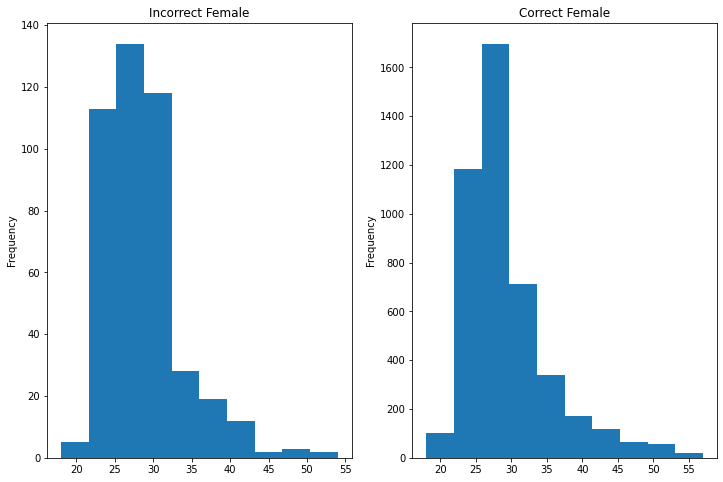

In [ ]:
make_hist(column='starting_age')

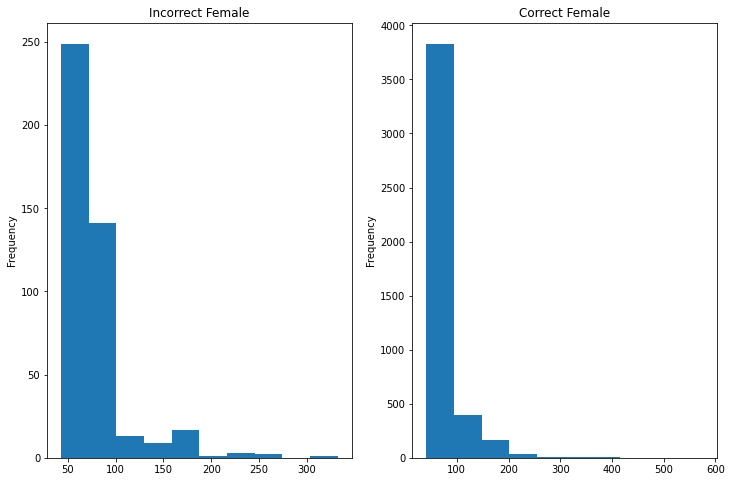

In [ ]:
make_hist(column='total_training_score')

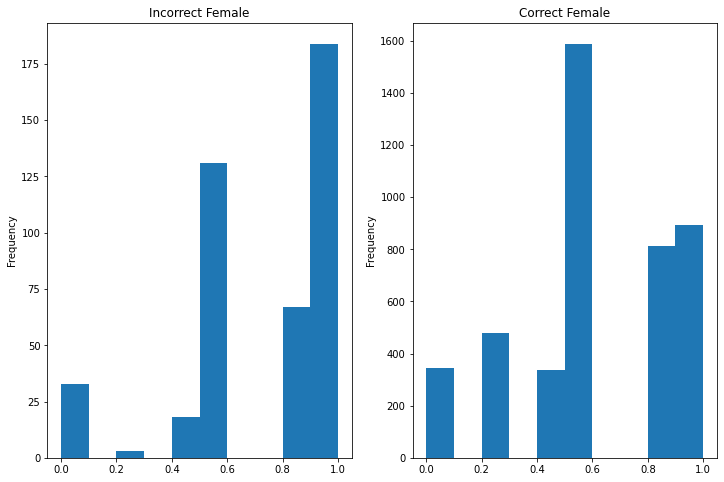

In [ ]:
make_hist(column='previous_year_rating_norm')

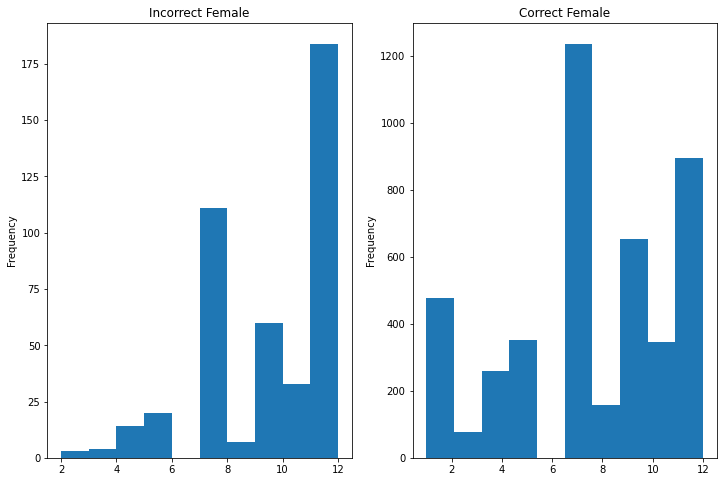

In [ ]:
make_hist(column='age_rating')

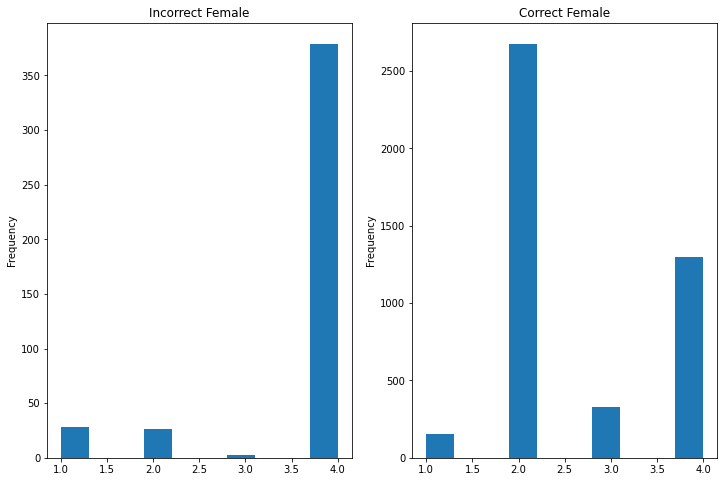

In [ ]:
make_hist(column='age_KPI')

In [ ]:
male_X_test['preds'] = male_pred

In [ ]:
male_X_test.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met>80%,awards_won?,avg_training_score,starting_age,total_training_score,previous_year_rating_norm,age_rating,age_KPI,preds
49286,0,31,2,1,2,1,34,4.0,9,0,0,87,25,87,0.8,9,2,0
5153,7,24,0,1,0,1,40,2.0,11,0,0,49,29,49,0.4,4,2,0
25050,4,11,0,1,2,1,30,5.0,2,1,0,59,28,59,1.0,12,4,0
46561,7,25,0,1,2,1,42,4.0,14,0,0,46,28,46,0.8,8,2,0
17616,4,11,0,1,1,2,35,5.0,7,0,0,61,28,122,1.0,12,2,0


In [ ]:
male_test = pd.merge(male_X_test, male_y_test, left_index=True, right_index=True)

In [ ]:
male_correct_test = male_test[male_test['is_promoted'] == male_test['preds']]

In [ ]:
male_incorrect_test = male_test[male_test['is_promoted'] != male_test['preds']]

In [ ]:
male_incorrect_test.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met>80%,awards_won?,avg_training_score,starting_age,total_training_score,previous_year_rating_norm,age_rating,age_KPI,preds,is_promoted
25050,4,11,0,1,2,1,30,5.0,2,1,0,59,28,59,1.0,12,4,0,1
5065,7,15,2,1,0,2,39,3.0,2,1,0,47,37,94,0.6,7,4,0,1
18290,7,11,0,1,1,2,28,5.0,6,1,0,48,22,96,1.0,12,4,0,1
32136,4,6,0,1,0,1,34,5.0,2,0,0,67,32,67,1.0,12,2,1,0
44153,6,14,2,1,2,1,29,0.0,1,1,0,77,28,77,0.0,10,4,0,1


In [ ]:
male_correct_test.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met>80%,awards_won?,avg_training_score,starting_age,total_training_score,previous_year_rating_norm,age_rating,age_KPI,preds,is_promoted
49286,0,31,2,1,2,1,34,4.0,9,0,0,87,25,87,0.8,9,2,0,0
5153,7,24,0,1,0,1,40,2.0,11,0,0,49,29,49,0.4,4,2,0,0
46561,7,25,0,1,2,1,42,4.0,14,0,0,46,28,46,0.8,8,2,0,0
17616,4,11,0,1,1,2,35,5.0,7,0,0,61,28,122,1.0,12,2,0,0
28738,4,28,2,1,0,1,49,3.0,18,0,0,57,31,57,0.6,5,3,0,0


In [ ]:
male_incorrect_test.shape

(968, 19)

In [ ]:
male_correct_test.shape

(10581, 19)

In [ ]:
def make_hist(column):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
  ax1 = male_incorrect_test[column].plot(kind='hist', ax=axes[0])
  ax2 = male_correct_test[column].plot(kind='hist', ax =axes[1])
  ax1.set_title('Incorrect Male')
  ax2.set_title('Correct Male')

In [ ]:
male_incorrect_test.columns

Index(['department', 'region', 'education', 'gender', 'recruitment_channel',
       'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service',
       'KPIs_met>80%', 'awards_won?', 'avg_training_score', 'starting_age',
       'total_training_score', 'previous_year_rating_norm', 'age_rating',
       'age_KPI', 'preds', 'is_promoted'],
      dtype='object')

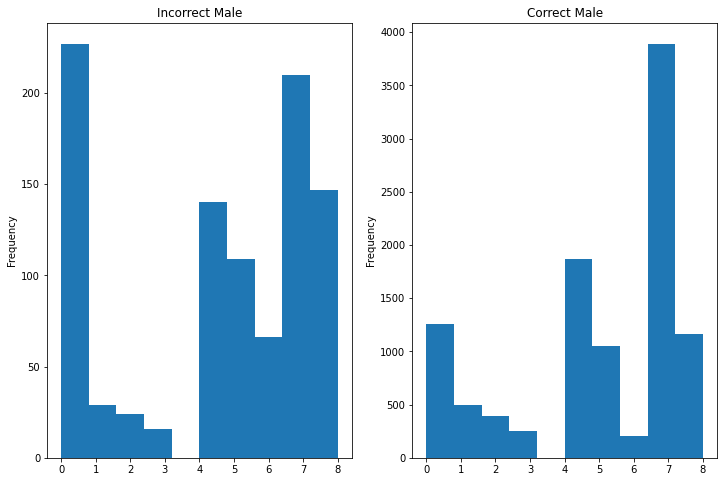

In [ ]:
make_hist(column='department')

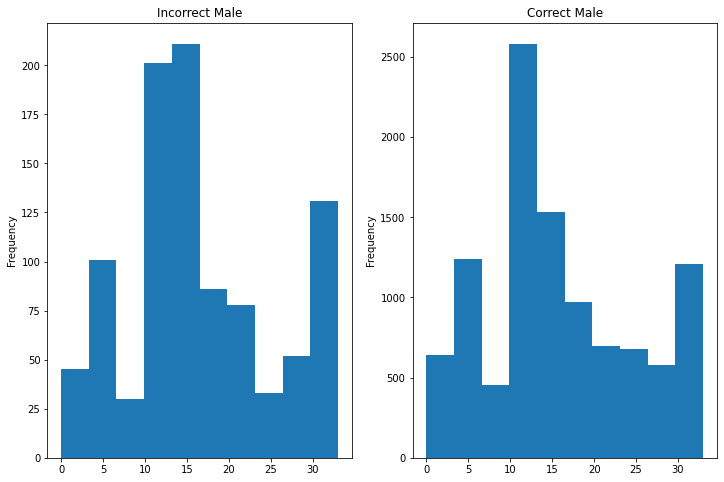

In [ ]:
make_hist(column='region')

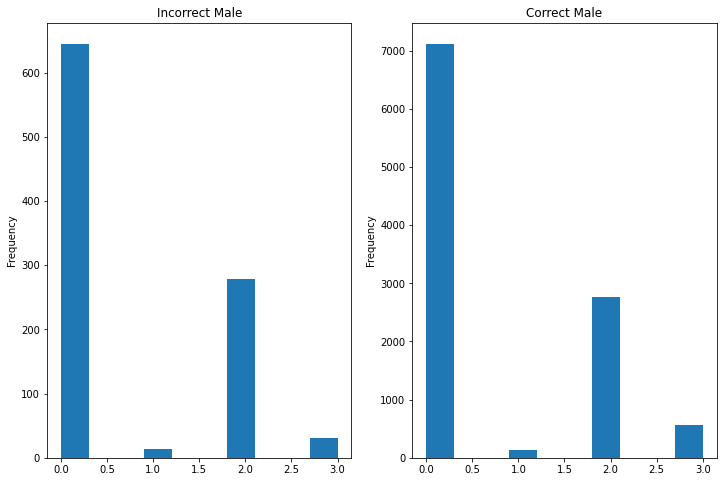

In [ ]:
make_hist(column='education')

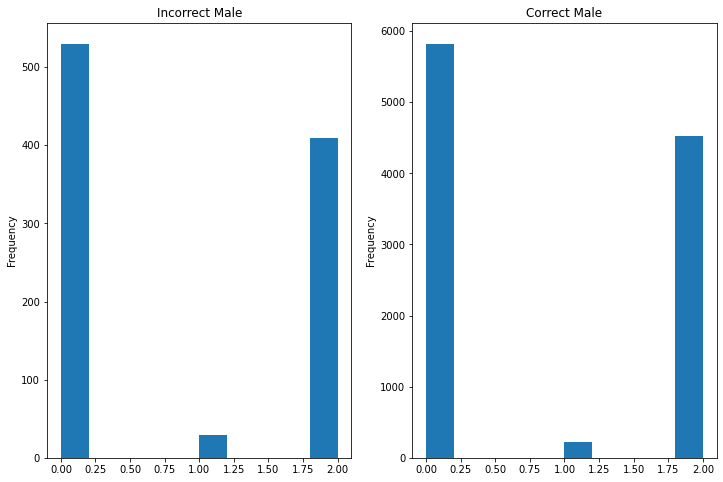

In [ ]:
make_hist(column='recruitment_channel')

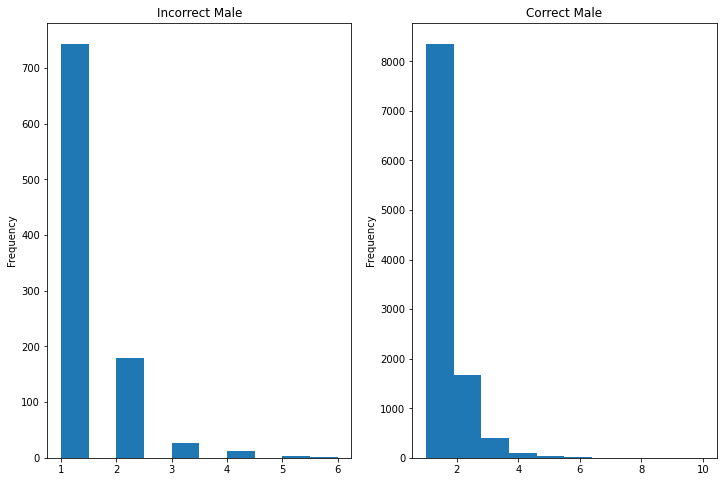

In [ ]:
make_hist(column='no_of_trainings')

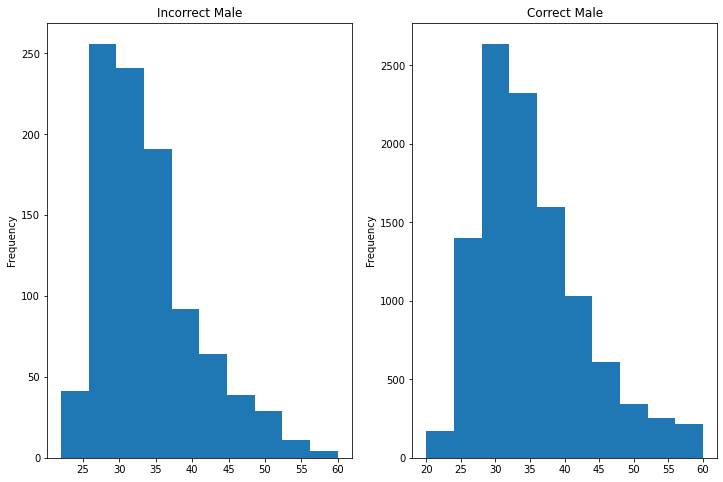

In [ ]:
make_hist(column='age')

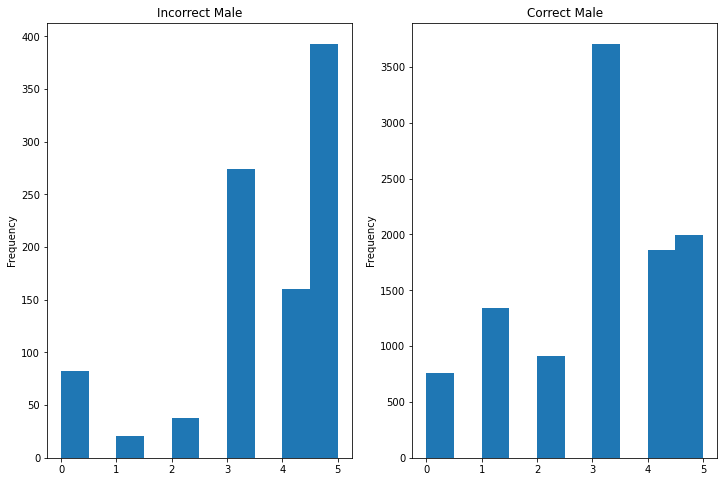

In [ ]:
make_hist(column='previous_year_rating')

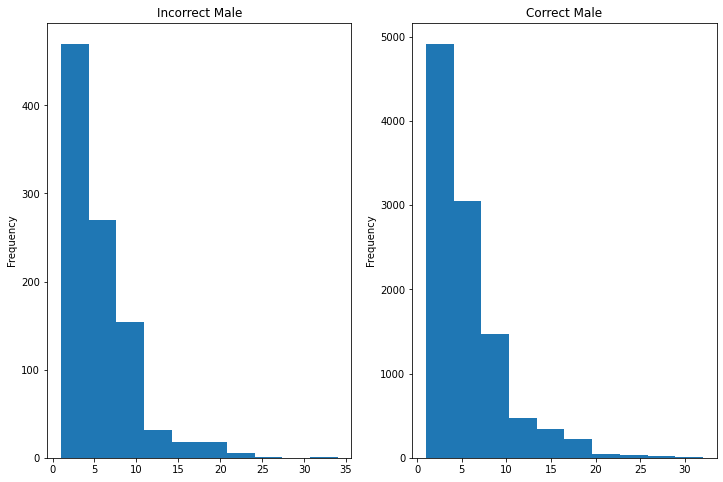

In [ ]:
make_hist(column='length_of_service')

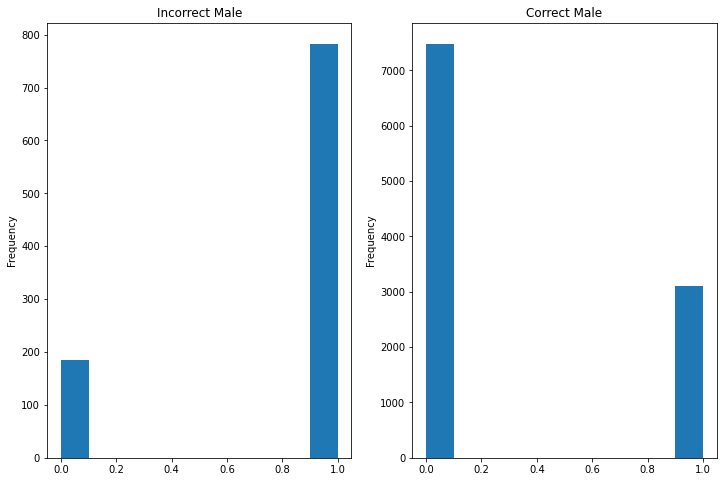

In [ ]:
make_hist(column='KPIs_met>80%')

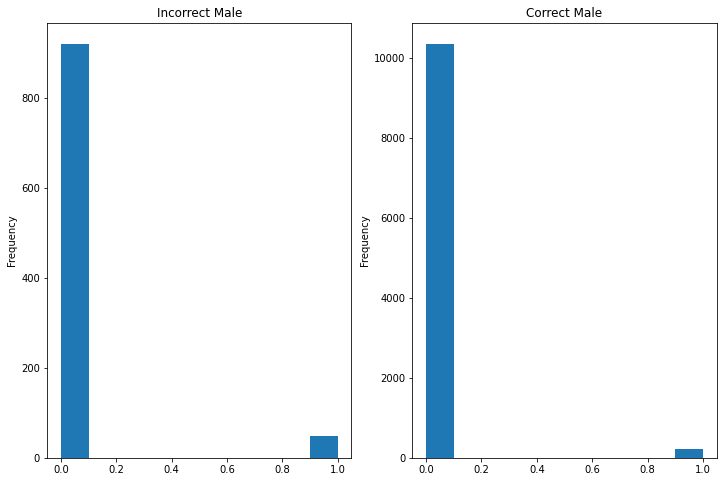

In [ ]:
make_hist(column='awards_won?')

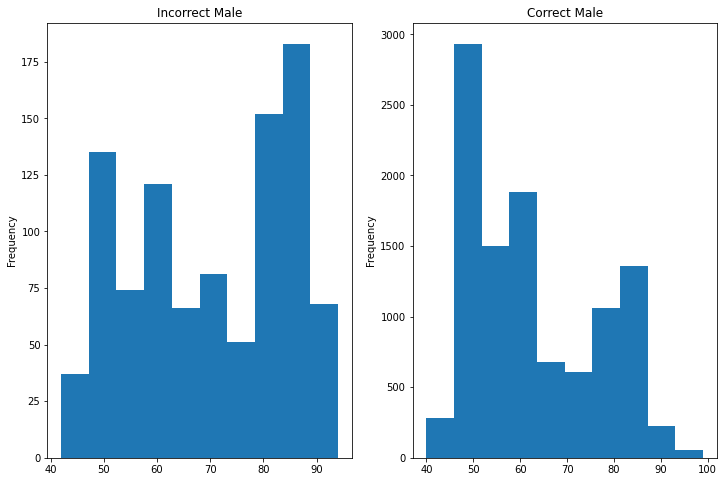

In [ ]:
make_hist(column='avg_training_score')

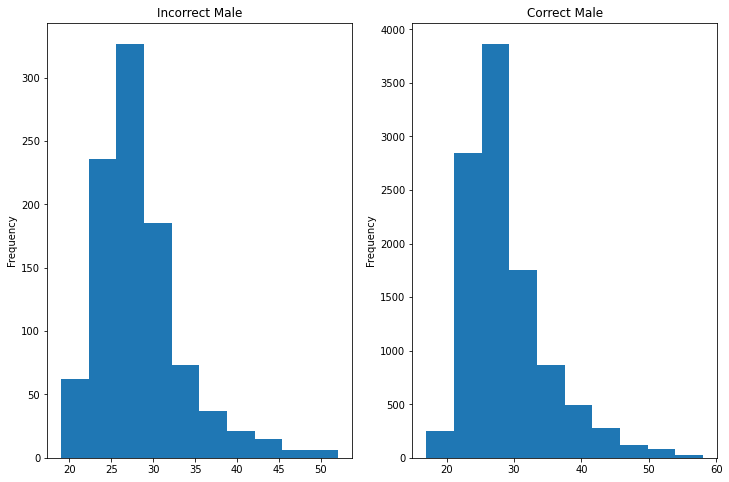

In [ ]:
make_hist(column='starting_age')

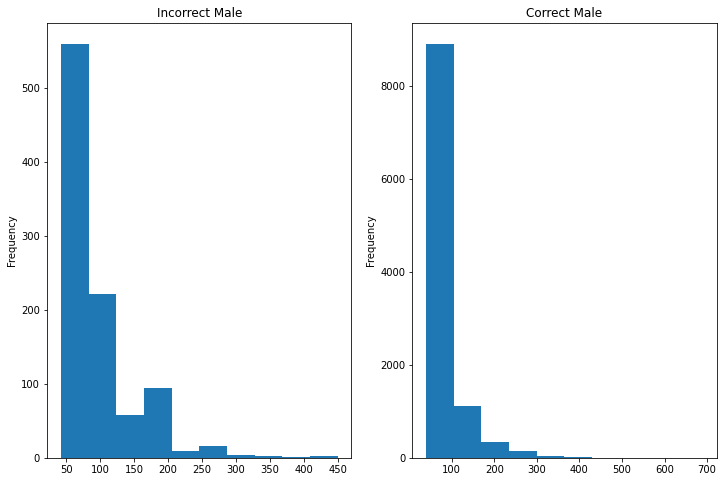

In [ ]:
make_hist(column='total_training_score')

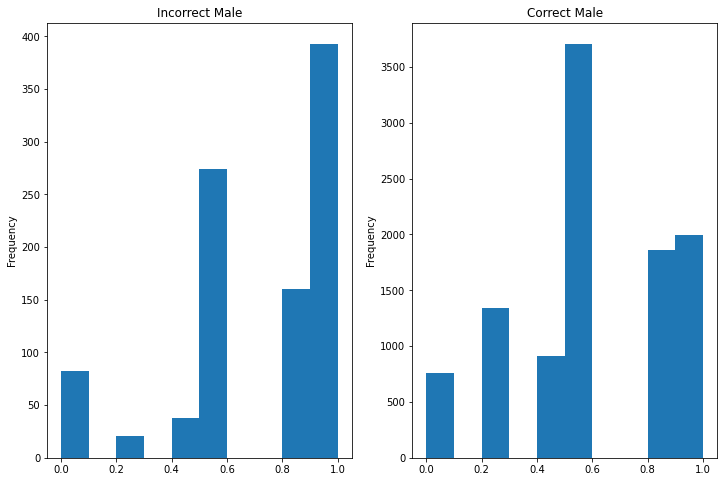

In [ ]:
make_hist(column='previous_year_rating_norm')

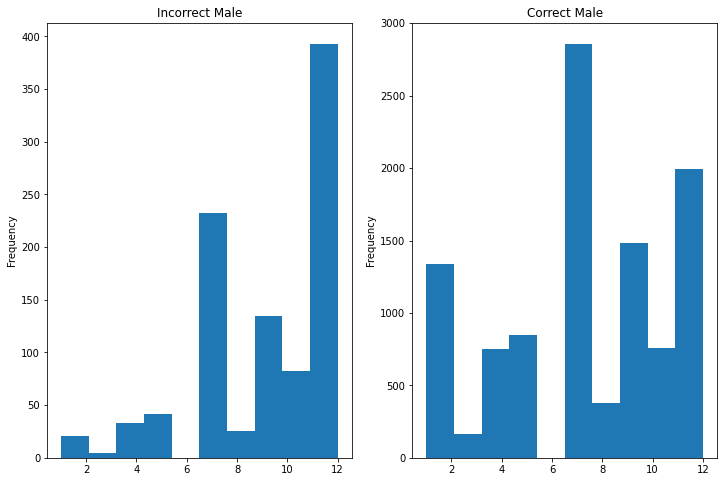

In [ ]:
make_hist(column='age_rating')

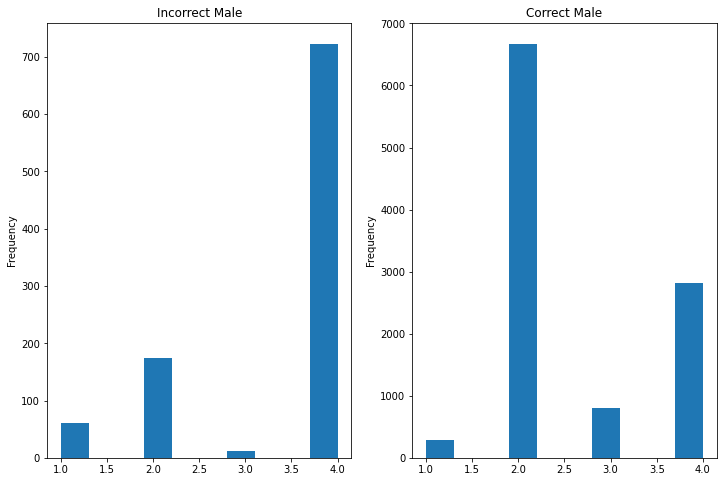

In [ ]:
make_hist(column='age_KPI')